# Stock Price Prediction News Sentiment Analysis and Network Analysis

**DATA 620 Web Analytics, CUNY Spring 2018**

**Team 3 - Rafal Decowski, Tze Fung Lung, Yun Mai, Ahsanul Choudhury **

** Goals: **

1. Score Nasdaq News as positive or negative events (Sentiment Analysis)
2. Analyze whether news sentiment is associated with stock price movement (Time Series Data) 
3. Create an optimized network of the most positive news (Networks & Island Method)

**Methodology:**


- Using a predefined portfolio of 20 stocks, we will scrape news data from Nasdaq (content along with the metadata like title and publishing date)
- The content of the news will be broken down into 1-word tokens and matched against the sentiment tokens.
- A score of (pos-neg) will be calculated for each article and labeled as positive or negative predicted effect
- The news-sentiment data will be then aligned with Yahoo!'s historical price data for the entire portfolio.
- We will use regression plots to estimate any trends in correlation between sentiment scores and price fluctuations. 



** Data sources:**

- ***[Twitte Sentiment](https://twitter.com)*** - A _term > sentiment-score_, cases of positive and negative words 

- **[Nasdaq News](https://www.nasdaq.com/symbol/aapl/news-headlines)** Scraped the latest news for items in the portfolio

- **[Yahoo Stock Prices](https://finance.yahoo.com/quote/)** Manually downloaded historical price information





In [227]:
from nltk.corpus import names as names_ntlk
import nltk
import pandas as pd
import matplotlib
import statistics
import scipy
from IPython.display import display
matplotlib.style.use('ggplot')

import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import seaborn as sns

import csv
import time
import requests
from bs4 import BeautifulSoup
import re
import seaborn
from nltk.tokenize import word_tokenize # or use some other tokenizer

from urllib.request import urlopen

# Normalizations
from sklearn.preprocessing.data import QuantileTransformer

%matplotlib inline

# Sentiment Data

Simple data of 2 features - _term_ & _score_ from Twitter

We will take a more statistical approach to fix the skewness of our data.



In [210]:
sentiment = pd.read_csv('D:\\Rafal\\CUNY\\620\\final\\data\\sentiment.csv', encoding='windows-1252')
sentiment.head()

,term,score
0,. #perfection,8.888
1,. #excellent,8.650
2,. #nice,8.421
3,. #fabulous,8.403
4,. #ideal,8.339


In [211]:
print('There are', sentiment.term.nunique(), 'unique words')

There are 369199 unique words


## Score Normalization

Initial explorations showed high scoring skewness in the negative direction. To minimize this problem we will use a Quantile Transformer to **bring the distribution to normal as close as possible**.


In [212]:
# Normalize the scores to make the interpretation and labeling statistically significant 
sentiment['norm_score'] = QuantileTransformer(output_distribution='normal').fit_transform(sentiment.score.reshape(-1, 1))


C:\Users\Rafal\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


**The graph below represents a normalized distribution of the scores.**

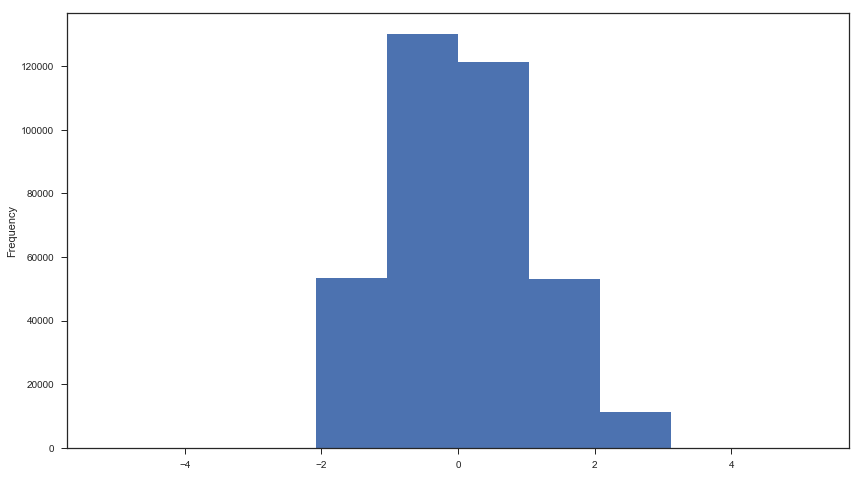

In [433]:
plt.figure(figsize=(14,6))
sentiment.norm_score.plot(kind='hist')

## Label Setting based on the quantile distribution


Since the distribution has been normalized, we will now create custom labels using the 25th and 75th quantile values as our thresholds. Everything in between will be considered as a low impacting news and marked as neutral.

In [424]:
quants = sentiment.norm_score.quantile([0.25,0.75])
quants # 25% & 75% quantile values 

0.25   -0.680013
0.75    0.321611
Name: norm_score, dtype: float64

Classify based on the quantiles

- **negative < 0.25 < neutral < 0.75 < positive**

In [216]:
sentiment['label'] = 'neutral'
sentiment.loc[sentiment.norm_score < quants.iloc[0], 'label'] = 'negative' 
sentiment.loc[sentiment.norm_score > quants.iloc[1], 'label']= 'positive' 

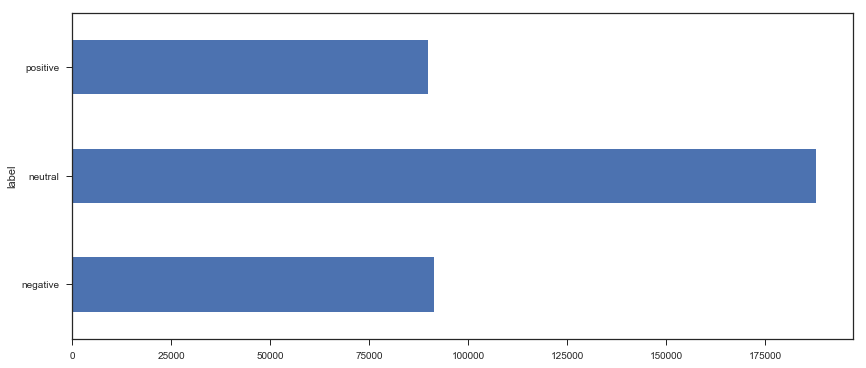

In [435]:
plt.rcParams['figure.figsize'] = [14, 6]
sentiment.groupby('label').count().term.plot(kind='barh')

<hr style="height:2px;border:none;color:#333;background-color:#333;" />

# Nasdaq portfolio

Leveraged the expertise of Bloomberg and a list of the best performing stocks in 2018.

https://seekingalpha.com/article/4185058-50-best-performing-s-and-p-500-stocks-1h-2018




In [436]:
# 20 best performing stock portfolio
# Build a list of companies and their nasdaq symbols   
portfolio = ['ABMD', 'NFLX', 'TWTR', 'TRIP', 'XL', 'UA', 'ALGN', 'M', 'CMG', 'AMD', 
             'AMZN', 'FOXA', 'NTAP', 'HES', 'HES', 'IDXX', 'ADBE', 'STX', 'APC', 'KSS', 'APP']

# Nasdaq News Data


To extract Nasdaq News, we developed a function that takes the portfolio as an argument and extracts **10 latest news**.

**[Nasdaq News Scraping]()**

_Good web scraping practice is to save all downloaded results to a local file and continue to work from your own source._



In [288]:
# Load News from local file
news_df = pd.read_csv('D:\\Rafal\\CUNY\\620\\final\\data\\news.csv', encoding='windows-1252')

# Convert to date format
news_df.Date = pd.to_datetime(news_df.Date)

# Sort by Date
news_df = news_df.sort_values('Date')
news_df.head()

,Contents,Date,Symbol,Titles,URLS
155,"For Immediate Release Chicago, IL - July...",2018-07-03,STX,zacks industry outlook highlights netapp super...,https://www.nasdaq.com/article/zacks-industry-...
154,International Business Machines IBM has ...,2018-07-03,STX,ibm to digitalize banca carige australian gove...,https://www.nasdaq.com/article/ibm-to-digitali...
135,Reuters @media screen and (max-device-width: ...,2018-07-03,IDXX,us stocks on the movepepsi spero nordstrom st...,https://www.nasdaq.com/article/us-stocks-on-th...
153,"We're just over halfway through 2018, so it's ...",2018-07-03,STX,the 5 best sp 500 high dividend stocks of 2018...,https://www.nasdaq.com/article/the-5-best-sp-5...
66,"We're just over halfway through 2018, so it's ...",2018-07-03,M,the 5 best sp 500 high dividend stocks of 2018...,https://www.nasdaq.com/article/the-5-best-sp-5...


## Label Classification

Break down the article contents into undividual words/tokens


In [289]:
news_df['tokenized'] = news_df.Contents.apply(lambda row: nltk.word_tokenize(row))

In [291]:
news_df.tokenized.head(10)

155    [For, Immediate, Release, Chicago, ,, IL, -, J...
154    [International, Business, Machines, IBM, has, ...
135    [Reuters, @, media, screen, and, (, max-device...
153    [We, 're, just, over, halfway, through, 2018, ...
66     [We, 're, just, over, halfway, through, 2018, ...
47     [Investors, in, Under, Armour, Inc, (, Symbol,...
152    [What, happened, Shares, of, hard-drive, giant...
44     [What, happened, Shares, of, Under, Armour, (,...
46     [In, this, segment, from, the, Motley, Fool, M...
134    [Reuters, @, media, screen, and, (, max-device...
Name: tokenized, dtype: object

**Look up the above tokenized articles in the sentiment dataframe and count matched words as positive or negative  **

In [279]:
pos = []
neg = []
for art in news_df.tokenized:
    pos.append(int(sentiment[sentiment.term.isin(art)].groupby('label').term.count().positive))
    neg.append(int(sentiment[sentiment.term.isin(art)].groupby('label').term.count().negative))

** Create a label based on the sum of words found in the sentiment list**

In [292]:
news_df['pos'] = pos
news_df['neg'] = neg
news_df['score'] = news_df['pos'] - news_df['neg']
news_df['label'] = np.where(news_df['score'] > 0, 'positive', 'negative')
news_df.head()

,Contents,Date,Symbol,Titles,URLS,tokenized,pos,neg,score,label
155,"For Immediate Release Chicago, IL - July...",2018-07-03,STX,zacks industry outlook highlights netapp super...,https://www.nasdaq.com/article/zacks-industry-...,"[For, Immediate, Release, Chicago, ,, IL, -, J...",71,100,-29,negative
154,International Business Machines IBM has ...,2018-07-03,STX,ibm to digitalize banca carige australian gove...,https://www.nasdaq.com/article/ibm-to-digitali...,"[International, Business, Machines, IBM, has, ...",53,49,4,positive
135,Reuters @media screen and (max-device-width: ...,2018-07-03,IDXX,us stocks on the movepepsi spero nordstrom st...,https://www.nasdaq.com/article/us-stocks-on-th...,"[Reuters, @, media, screen, and, (, max-device...",24,21,3,positive
153,"We're just over halfway through 2018, so it's ...",2018-07-03,STX,the 5 best sp 500 high dividend stocks of 2018...,https://www.nasdaq.com/article/the-5-best-sp-5...,"[We, 're, just, over, halfway, through, 2018, ...",45,62,-17,negative
66,"We're just over halfway through 2018, so it's ...",2018-07-03,M,the 5 best sp 500 high dividend stocks of 2018...,https://www.nasdaq.com/article/the-5-best-sp-5...,"[We, 're, just, over, halfway, through, 2018, ...",45,62,-17,negative


** Aggregate score by symbol and date ** 

In [305]:
sen_news = pd.DataFrame({'score' : news_df.groupby( ["Symbol", "Date"])['score'].sum()}).reset_index()
sen_news.head()

,Symbol,Date,score
0,ABMD,2018-07-10,-14
1,ABMD,2018-07-11,-19
2,ABMD,2018-07-12,3
3,ABMD,2018-07-13,-5
4,ABMD,2018-07-16,-52


# Yahoo Stock Data

In [317]:
prices = pd.read_csv('D:\\Rafal\\CUNY\\620\\final\\data\\prices\\prices.csv')

# Convert to date format
prices.Date = pd.to_datetime(prices.Date)

# Sort by Date
prices = prices.sort_values('Date')

prices.head()

** Calculate a new feature _CHANGE_ to indicate the difference between opening price and closing price. **

In [319]:
prices['change'] = round(prices['Close'] - prices['Open'],2)
prices.head()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,change
0,ABMD,2018-06-20,441.100006,450.929993,441.100006,446.209991,446.209991,583000,5.11
84,AMZN,2018-06-20,1742.500000,1762.930054,1741.359985,1750.079956,1750.079956,4332600,7.58
42,ALGN,2018-06-20,368.010010,369.200012,362.690002,364.700012,364.700012,794200,-3.31
105,APC,2018-06-20,69.769997,70.389999,68.739998,70.099998,70.099998,4941400,0.33
126,CMG,2018-06-20,469.299988,470.760010,462.160004,465.500000,465.500000,372800,-3.80


# Merge Sentiment-labeled news data and merge it with prices by symbol and date

In [337]:
final = sen_news.merge(prices, left_on=['Symbol', 'Date'], right_on=['Symbol', 'Date'], how='outer')
final_nonans =  final.dropna(subset=['score'], axis='rows')

In [363]:
final_nonans.head()

,Symbol,Date,score,Open,High,Low,Close,Adj Close,Volume,change
0,ABMD,2018-07-10,-14.0,413.089996,413.500000,399.730011,405.149994,405.149994,644800.0,-7.94
1,ABMD,2018-07-11,-19.0,402.670013,408.000000,399.179993,403.790009,403.790009,398900.0,1.12
2,ABMD,2018-07-12,3.0,408.190002,415.019989,408.160004,414.609985,414.609985,1290500.0,6.42
3,ABMD,2018-07-13,-5.0,416.230011,421.109985,413.869995,418.760010,418.760010,530000.0,2.53
4,ABMD,2018-07-16,-52.0,419.329987,421.760010,417.059998,419.380005,419.380005,610800.0,0.05


In [339]:
final_nonans[final_nonans.Symbol == 'ABMD'][['Date', 'score', 'change']]

,Date,score,change
0,2018-07-10,-14.0,-7.94
1,2018-07-11,-19.0,1.12
2,2018-07-12,3.0,6.42
3,2018-07-13,-5.0,2.53
4,2018-07-16,-52.0,0.05
5,2018-07-17,-41.0,9.76
6,2018-07-18,-45.0,1.36
7,2018-07-19,-45.0,-5.95


# Visualize Sentiment & Price Time Series

** Pick any of the symbols and assign it to _sym_ variable for plotting **

In [365]:
print(portfolio)

['ABMD', 'NFLX', 'TWTR', 'TRIP', 'XL', 'UA', 'ALGN', 'M', 'CMG', 'AMD', 'AMZN', 'FOXA', 'NTAP', 'HES', 'HES', 'IDXX', 'ADBE', 'STX', 'APC', 'KSS', 'APP']


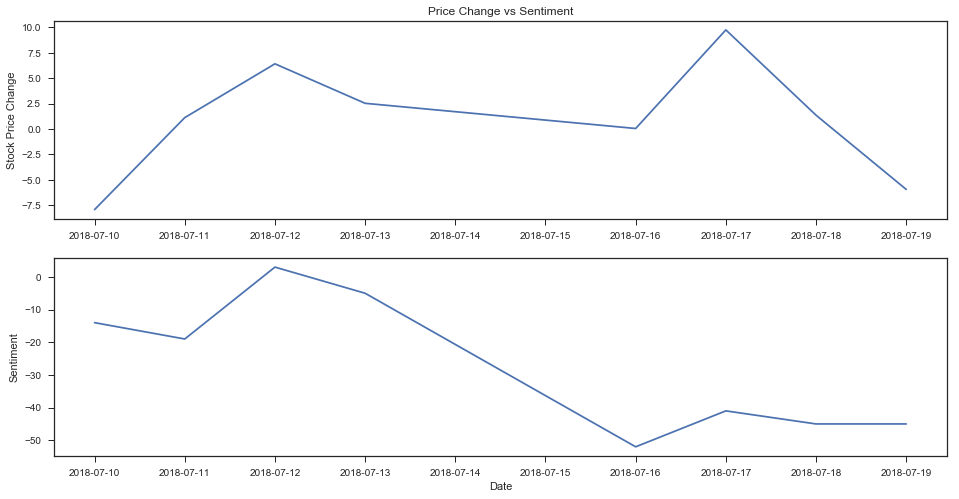

In [421]:
# Idexx Laboratories
sym = 'ABMD'

plt.figure(figsize=(16,8))

x = final_nonans[final_nonans.Symbol == sym].Date

y1 = final_nonans[final_nonans.Symbol == sym].change
y2 = final_nonans[final_nonans.Symbol == sym].score

plt.subplot(2, 1, 1)
plt.plot(x, y1)
plt.title('Price Change vs Sentiment')
plt.ylabel('Stock Price Change')

plt.subplot(2, 1, 2)
plt.plot(x, y2)
plt.xlabel('Date')
plt.ylabel('Sentiment')

plt.show()

Text(0.5,1,'Price Change vs Sentiment Score')

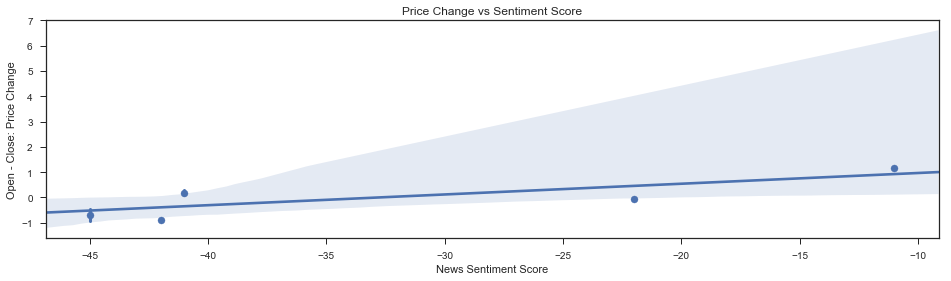

In [423]:
sym = 'STX'

plt.figure(figsize=(16,4))

ax = sns.regplot(x='score', y='change', data=final_nonans[final_nonans.Symbol == sym], x_estimator=np.mean)
plt.xlabel('News Sentiment Score')
plt.ylabel('Open - Close: Price Change')
plt.title('Price Change vs Sentiment Score')

# Portfolio Networkx 

We are further checking the direction of stock shares or index to find out any opportunity of investment, like buy stocks in positive intention or sold stocks in negative intention.

General computer need to operate each stock share more than 5 minutes, so we are now operating only 3 stock sentiment analysis here. Around 15 minutes waiting for processing, if it operate in real, we need a more high efficient processor and computer to do it. (Nasdaq will block the access IP if over accessing information)

1. Scraping news from Nasdaq for specific stocks ticker symbol
2. Using beautifulsoup to loop required stocks or index, and use word_tokenize function to get the text instead of using get_text() in beautifulsoup to avoid error scraping for sentiment analysis
4. Getting the result - positive or negative trend from each stocks share
5. Generating the dataframe to create networkx connection graph

#### Networkx Graph
We will use stock as one set of nodes and direction as the other. This should lead us to a bipartite graph.

In addition, there is a weight associated with every edge. The weight represents the lastsale price of stock to create multiple islands.

In [371]:
stockpred = pd.read_csv("https://raw.githubusercontent.com/data620team3/data620team3/master/finalproject/stock.csv")
stockpred.head()

,stock,direction,LastSale
0,PIH,positive,7.2000
1,PIHPP,positive,25.5000
2,TURN,positive,2.1675
3,FLWS,negative,12.8000
4,FCCY,negative,21.4500


In [372]:
# Networkx graph with two sets of bipartite nodes
B = nx.Graph()
B.add_nodes_from(stockpred['stock'], bipartite=0)
B.add_nodes_from(stockpred['direction'], bipartite=1)

# Extract data from the main dataframe and add as weighted edges
weighted_edges = stockpred[['stock', 'direction','LastSale']].T.apply(tuple).tolist()
B.add_weighted_edges_from(weighted_edges)


In [373]:
# Capture Biggest connected graph and test
B = max(nx.connected_component_subgraphs(B), key=len)
nx.is_connected(B)


True

In [374]:
stock_nodes = set(n for n,d in B.nodes(data=True) if d['bipartite']==0)
direction_nodes = set(B) - stock_nodes


#### Island method

In [375]:
def trim_edges(g, weight=1):
    g2 = nx.Graph()
    
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
            
    return g2

In [376]:
def island_method(g, iterations=6):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [377]:
cc = sorted(nx.connected_component_subgraphs(B), key = len, reverse=True)[0]
#    sorted(nx.connected_component_subgraphs(team_win), key = len, reverse=True)[0]
islands = island_method(cc)
 
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print (i[0], len(i[1]), len(sorted(nx.connected_component_subgraphs(i[1]), key = len, reverse=True)))

0 521 1
303 11 1
606 3 1
909 3 1
1212 2 1
1515 2 1
1818 2 1


It has 7 iterations on the biggest connected graph from the entire dataset. Although it is only positive and negative of direction nodes, but it is a good way to show the edge weight by lastsale price. 

The first one will visualize the most important and highest island with one positive direction with 521 stock shares.


### Visualization

Most of stock nodes are placed on first largest island with total 521 nodes with positive direction. 

Green color is stock, Orange color is direction - positive. 


### First Island Visualization
For the weight of all range stock price, it has 521 stock shares with one positive direction.

In [378]:
# Create a list of colors based on the node name

node_colors = []
for n in islands[0][1].nodes(data=True):
    if n[0] in stock_nodes:
        node_colors.append('#bf8a40')
    else:
        node_colors.append('#40bf80')


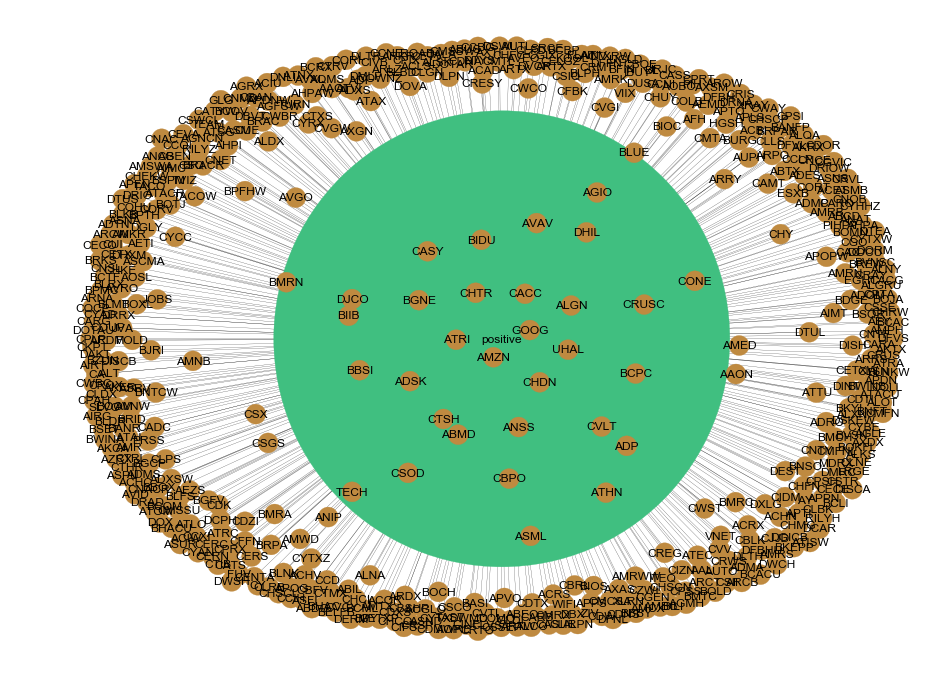

In [379]:
plt.rcParams['figure.figsize'] = [16, 12]

pos = nx.spring_layout(islands[0][1], k=2) # k=2 values helps spread the nodes

# Degree calculations to denote the size of nodes
degree = dict(nx.degree(islands[0][1]))


degree_graph = nx.draw_networkx(islands[0][1], 
                                pos=pos,
                                node_color=node_colors,
                                node_size=np.multiply(list(degree.values()), 400), # multiply degree by 400 for better resolution
                                with_labels=True, 
                                width=0.2)

# Remove axis
limits=plt.axis('off')

### Second Island Visualization
For the weight of stock price more than 303, it has 11 stock shares with one positive direction.

In [380]:
# Create a list of colors based on the node name

node_colors = []
for n in islands[1][1].nodes(data=True):
    if n[0] in stock_nodes:
        node_colors.append('#bf8a40')
    else:
        node_colors.append('#40bf80')

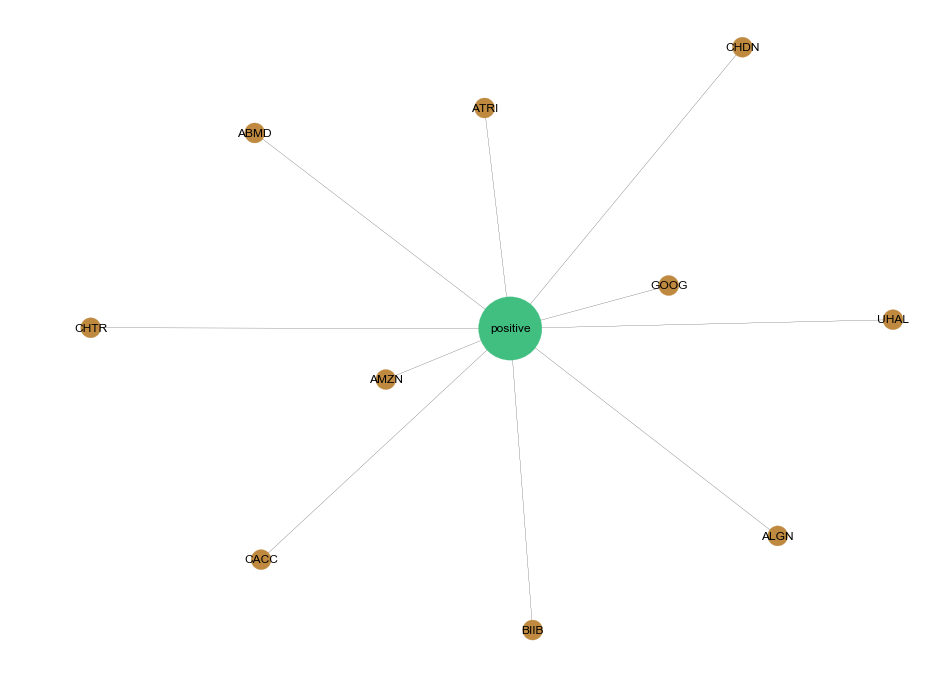

In [381]:
plt.rcParams['figure.figsize'] = [16, 12]

pos = nx.spring_layout(islands[1][1], k=2) # k=2 values helps spread the nodes

# Degree calculations to denote the size of nodes
degree = dict(nx.degree(islands[1][1]))


degree_graph = nx.draw_networkx(islands[1][1], 
                                pos=pos,
                                node_color=node_colors,
                                node_size=np.multiply(list(degree.values()), 400), # multiply degree by 400 for better resolution
                                with_labels=True, 
                                width=0.2)

# Remove axis
limits=plt.axis('off')

For the second island visualization, it has 10 stock shares nodes with one positive direction node, and the closeness nodes with central positive node show the weight of price value, like amazon and google are highest value of price comparing with all selected stocks.

## Conclusion
For sentiment analysis, more number of words dictionary will get more accurancy result for analsis, but it requires longer processing time to operate scraping, words cleaning, tokenizing and testing for large number amount of words, like we need 5 mins to operate each stock share. The example index, like nasdaq, the sentiment test result is negative on 17th July 2018, it may reflect the downward of investment incentive and may affect the price of index. 

For network analysis, we use the result of sentiment dataset to create the weighted network, according to the weight and positive direction, we can make our investing decision for the price weighting, like closeness central nodes, we need higher investment cost like google and amazon. We should choose the positive direction of stock shares with proper price for our investiment. 
 

## Furture improvement
1. We can check the accuracy of prediction with the price movement, like positive test result with price increasing.
2. We can increase the accuracy of prediction by increasing the number of defintion dictionary.
3. To use high processing computer to operate the classify the large number of words.
4. We should find the other website for scraping information, Nasdaq will block the IP if over accessing, it is not a stable website for research analysis.

## Reference:
1. https://www.nasdaq.com
2. http://positivewordsresearch.com/sentiment-analysis-resources/#content